In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
base_dir = '/content/dataset'  # Path to the dataset
classes = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

# Create Train, Valid, Test folders
for folder in ['Train', 'Valid', 'Test']:
    for cls in classes:
        os.makedirs(os.path.join(base_dir, folder, cls), exist_ok=True)

# Function to split and move files
def split_and_move(class_name):
    class_path = os.path.join(base_dir, class_name)
    images = os.listdir(class_path)

    train_images, test_valid_images = train_test_split(images, test_size=0.5, random_state=42)
    valid_images, test_images = train_test_split(test_valid_images, test_size=0.5, random_state=42)

    for img in train_images:
        shutil.move(os.path.join(class_path, img), os.path.join(base_dir, 'Train', class_name, img))

    for img in valid_images:
        shutil.move(os.path.join(class_path, img), os.path.join(base_dir, 'Valid', class_name, img))

    for img in test_images:
        shutil.move(os.path.join(class_path, img), os.path.join(base_dir, 'Test', class_name, img))

# Apply the function to each class
for cls in classes:
    split_and_move(cls)

# Optionally, remove the original folders if they are empty
for cls in classes:
    os.rmdir(os.path.join(base_dir, cls))


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16 ,ResNet152V2,EfficientNetB7
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,Adamax,SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')


In [6]:
# Paths to your data
train_dir = '/content/dataset/Train'
valid_dir = '/content/dataset/Valid'
test_dir = '/content/dataset/Test'

# Image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=20, zoom_range=0.2)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(img_height, img_width),
                                                  batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 2108 images belonging to 4 classes.
Found 1053 images belonging to 4 classes.
Found 1056 images belonging to 4 classes.


In [7]:
def build_and_finetune_model(base_model, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [8]:
# Number of classes
num_classes = train_generator.num_classes


In [9]:
# VGG16
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
vgg16_model = build_and_finetune_model(vgg16_base, num_classes)
vgg16_history = vgg16_model.fit(train_generator, validation_data=valid_generator, epochs=15)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.3791 - loss: 1.3188 - val_accuracy: 0.5926 - val_loss: 1.1806
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 96s 682ms/step - accuracy: 0.6007 - loss: 1.1430 - val_accuracy: 0.5622 - val_loss: 1.0744
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 79s 628ms/step - accuracy: 0.6071 - loss: 1.0452 - val_accuracy: 0.5869 - val_loss: 0.9889
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 85s 694ms/step - accuracy: 0.6331 - loss: 0.9532 - val_accuracy: 0.6144 - val_loss: 0.9718
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 617ms/step - accuracy: 0.6412 - loss: 0.9342 - val_accuracy: 0.6914 - val_loss: 0.8970
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 84s 625ms/step - accuracy: 0.6566 - loss: 0.9074 - val_accuracy: 0.6315 - val_loss: 0.9145
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 605ms/step - accuracy: 0.6928 - loss: 0.8595 - val_accuracy: 0.6676 - val_loss: 0.8356
Epoch 8/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 84s 616ms/s

In [10]:
# ResNet152V2
resnet_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
resnet_model = build_and_finetune_model(resnet_base, num_classes)
resnet_history = resnet_model.fit(train_generator, validation_data=valid_generator, epochs=15)


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.5843 - loss: 0.9756 - val_accuracy: 0.7607 - val_loss: 0.6083
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 105s 652ms/step - accuracy: 0.7590 - loss: 0.6063 - val_accuracy: 0.7911 - val_loss: 0.5585
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 84s 680ms/step - accuracy: 0.7894 - loss: 0.5281 - val_accuracy: 0.7806 - val_loss: 0.5577
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 50s 706ms/step - accuracy: 0.8158 - loss: 0.4788 - val_accuracy: 0.8139 - val_loss: 0.5068
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 664ms/step - accuracy: 0.8244 - loss: 0.4550 - val_accuracy: 0.8129 - val_loss: 0.5061
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 48s 679ms/step - accuracy: 0.8431 - loss: 0.4249 - val_accuracy: 0.7968 - val_loss: 0.5204
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 665ms/step - accuracy: 0.8572 - loss: 0.3997 - val_accuracy: 0.8291 - val_loss: 0.4930
Epoch 8/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 48s 69

In [11]:
# EfficientNetB7
efficientnet_base = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
efficientnet_model = build_and_finetune_model(efficientnet_base, num_classes)
efficientnet_history = efficientnet_model.fit(train_generator, validation_data=valid_generator, epochs=15)

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step
Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.2515 - loss: 1.4131 - val_accuracy: 0.2602 - val_loss: 1.3930
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 50s 686ms/step - accuracy: 0.2524 - loss: 1.4201 - val_accuracy: 0.2602 - val_loss: 1.4173
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 709ms/step - accuracy: 0.2593 - loss: 1.4017 - val_accuracy: 0.2460 - val_loss: 1.4108
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 48s 686ms/step - accuracy: 0.2743 - loss: 1.4038 - val_accuracy: 0.2393 - val_loss: 1.4044
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 84s 710ms/step - accuracy: 0.2634 - loss: 1.4017 - val_accuracy: 0.2460 - val_loss: 1.3954
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 50s 718ms/step - accuracy: 0.2479 - loss: 1.4012 - val_accuracy: 0.2460 - val_loss: 1.3979
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 81s 691ms/step - accuracy: 0.2583 - loss: 1.4138 - val_accuracy: 0.2460 - val_loss: 1.3979
Epoch 8/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 717

33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 274ms/step
                      precision    recall  f1-score   support

            cataract       0.70      0.91      0.79       260
diabetic_retinopathy       0.94      0.77      0.85       275
            glaucoma       0.76      0.39      0.51       252
              normal       0.62      0.84      0.72       269

            accuracy                           0.73      1056
           macro avg       0.76      0.73      0.72      1056
        weighted avg       0.76      0.73      0.72      1056



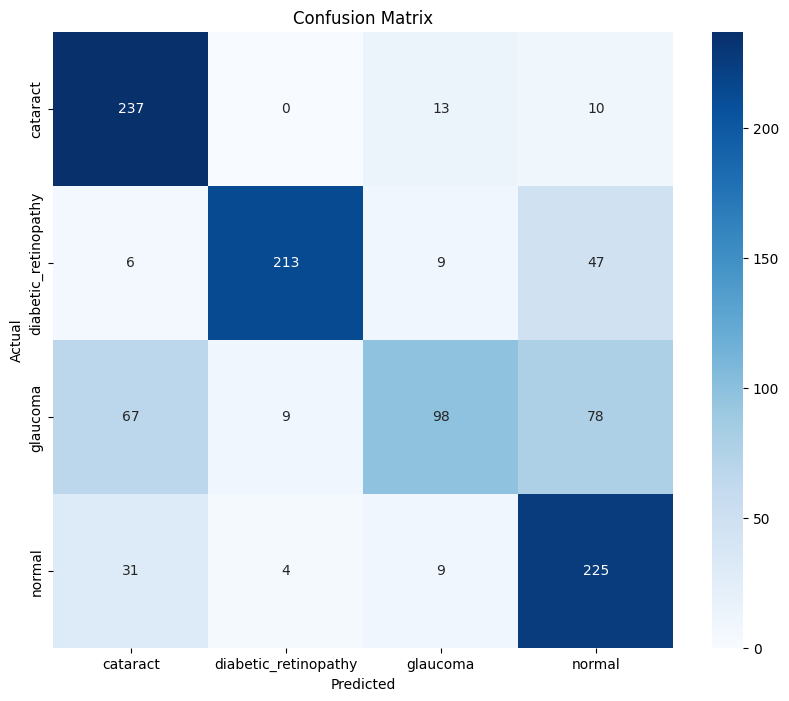

33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step
                      precision    recall  f1-score   support

            cataract       0.93      0.89      0.91       260
diabetic_retinopathy       0.84      0.86      0.85       275
            glaucoma       0.83      0.69      0.75       252
              normal       0.69      0.81      0.75       269

            accuracy                           0.81      1056
           macro avg       0.82      0.81      0.81      1056
        weighted avg       0.82      0.81      0.82      1056



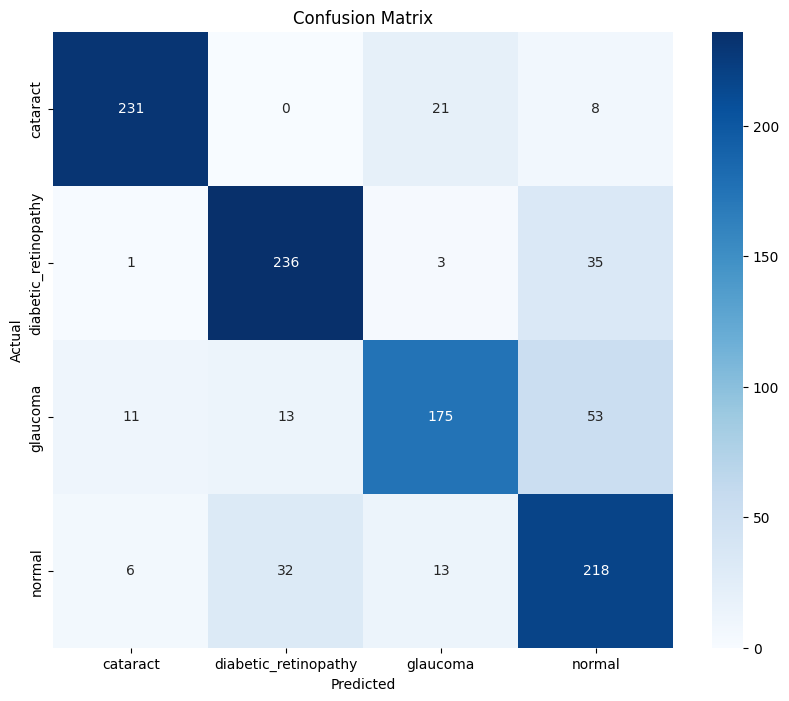

33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 342ms/step
                      precision    recall  f1-score   support

            cataract       0.25      1.00      0.40       260
diabetic_retinopathy       0.00      0.00      0.00       275
            glaucoma       0.00      0.00      0.00       252
              normal       0.00      0.00      0.00       269

            accuracy                           0.25      1056
           macro avg       0.06      0.25      0.10      1056
        weighted avg       0.06      0.25      0.10      1056



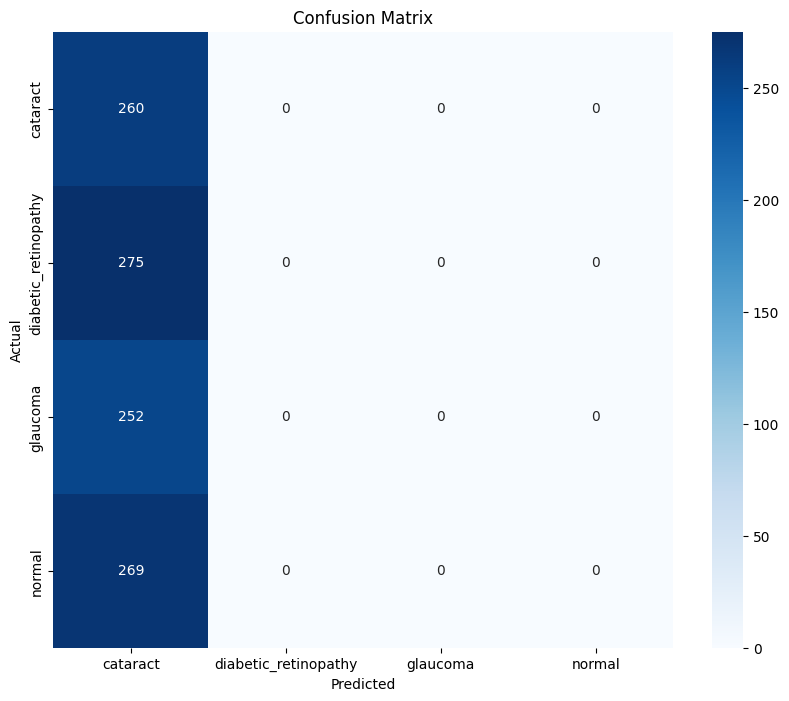

In [12]:
def evaluate_model(model, test_generator):
    # Predictions
    test_generator.reset()
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Classification Report
    class_labels = list(test_generator.class_indices.keys())
    report = classification_report(y_true, y_pred, target_names=class_labels)
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate VGG16
evaluate_model(vgg16_model, test_generator)

# Evaluate ResNet152V2
evaluate_model(resnet_model, test_generator)

# Evaluate EfficientNetB7
evaluate_model(efficientnet_model, test_generator)


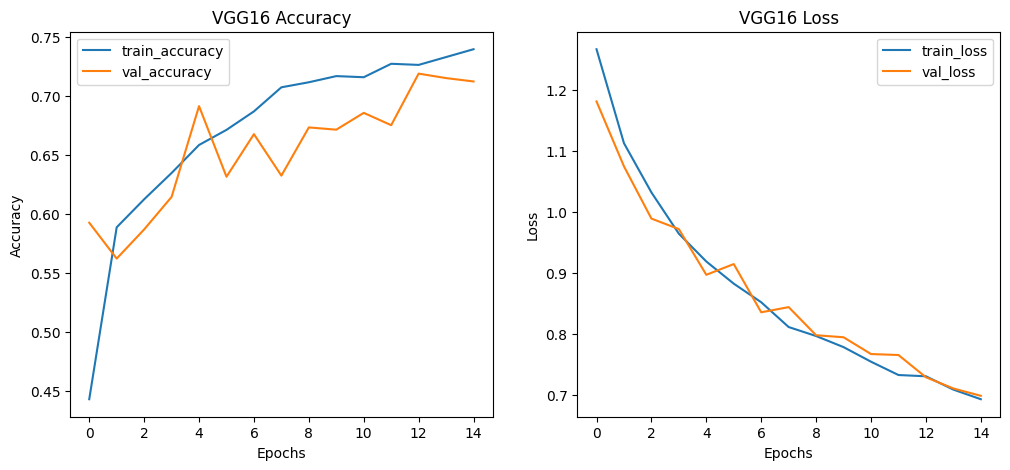

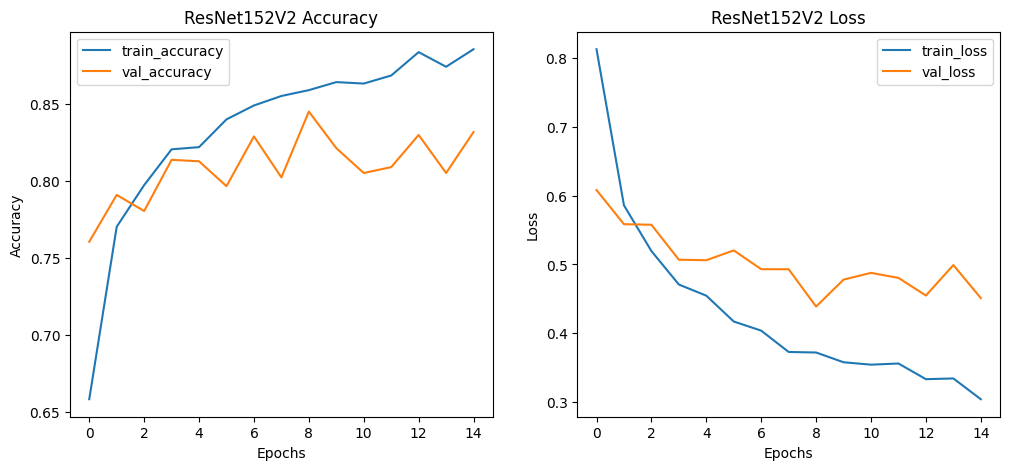

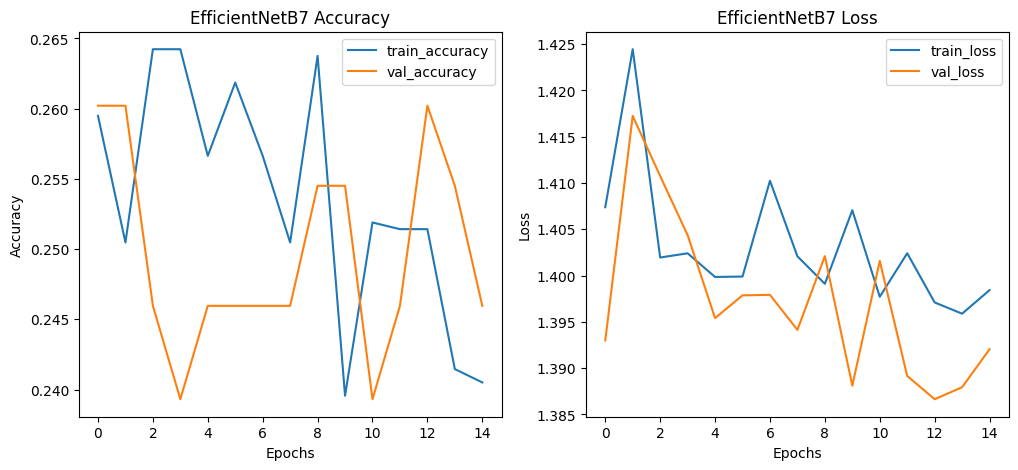

In [13]:
def plot_history(history, title):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot VGG16
plot_history(vgg16_history, 'VGG16')

# Plot ResNet152V2
plot_history(resnet_history, 'ResNet152V2')

# Plot EfficientNetB7
plot_history(efficientnet_history, 'EfficientNetB7')


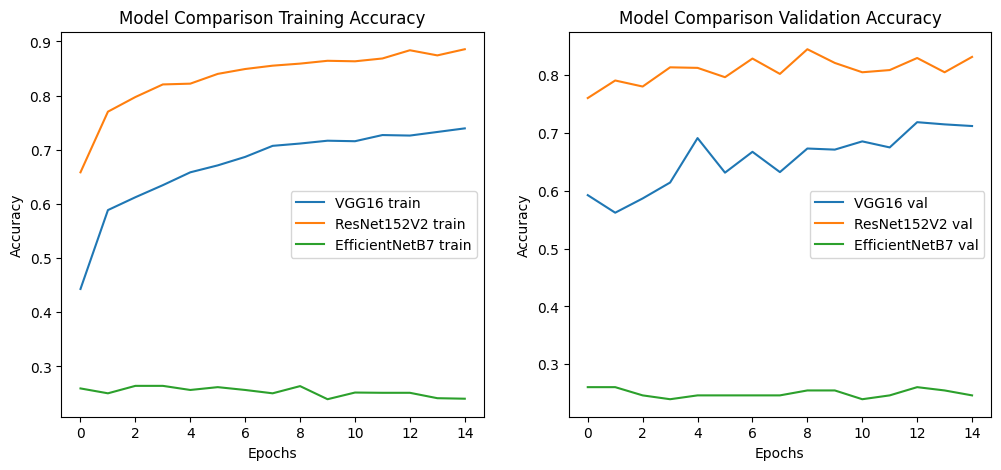

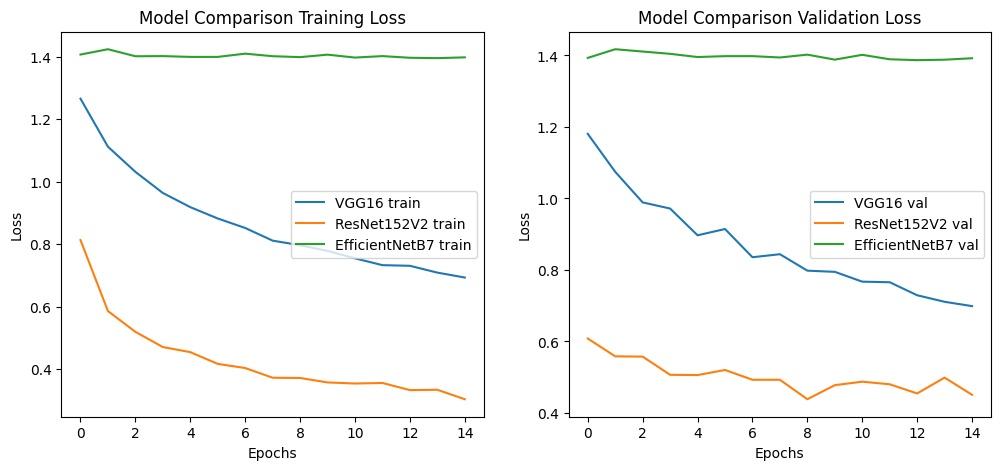

In [15]:
def plot_combined_histories(histories, title, metric):
    plt.figure(figsize=(12, 5))

    # Plot for training metric
    plt.subplot(1, 2, 1)
    for model_name, history in histories.items():
        plt.plot(history.history[metric], label=f'{model_name} train')
    plt.title(f'{title} Training {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()

    # Plot for validation metric
    plt.subplot(1, 2, 2)
    for model_name, history in histories.items():
        plt.plot(history.history[f'val_{metric}'], label=f'{model_name} val')
    plt.title(f'{title} Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()

    plt.show()

# Combine histories into a dictionary
histories = {
    'VGG16': vgg16_history,
    'ResNet152V2': resnet_history,
    'EfficientNetB7': efficientnet_history
}

# Plot combined accuracy
plot_combined_histories(histories, 'Model Comparison', 'accuracy')

# Plot combined loss
plot_combined_histories(histories, 'Model Comparison', 'loss')


33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 334ms/step


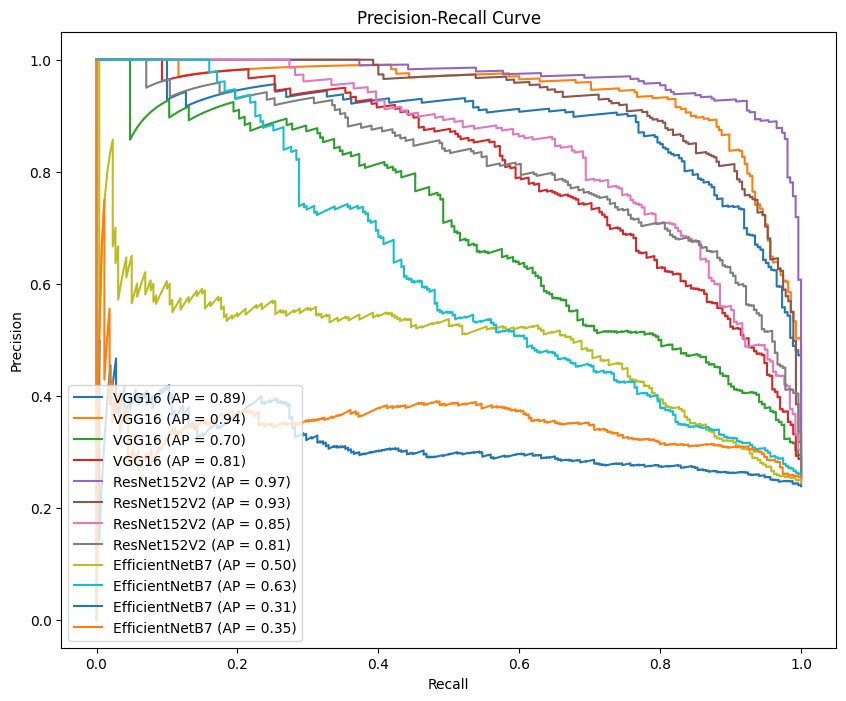

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(models, test_generator):
    plt.figure(figsize=(10, 8))

    for model_name, model in models.items():
        test_generator.reset()
        y_pred = model.predict(test_generator)
        y_true = test_generator.classes
        n_classes = len(test_generator.class_indices)
        precision = dict()
        recall = dict()
        average_precision = dict()

        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred[:, i])
            average_precision[i] = average_precision_score(y_true == i, y_pred[:, i])
            plt.plot(recall[i], precision[i], label=f'{model_name} (AP = {average_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()
    # Plot ROC curve
models = {
    'VGG16': vgg16_model,
    'ResNet152V2': resnet_model,
    'EfficientNetB7': efficientnet_model
}

# Plot Precision-Recall curve
plot_precision_recall_curve(models, test_generator)
